In [151]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import math
import numpy as np
from numba import njit
import cv2

In [233]:
img = Image.open("../images/ren.jpg")

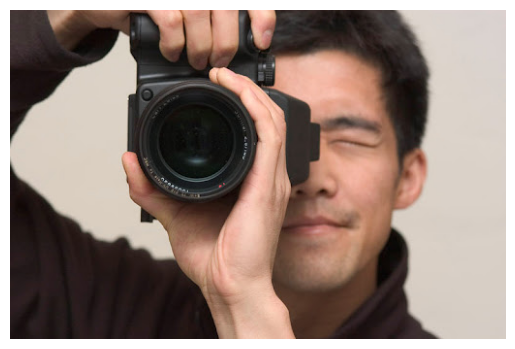

In [234]:
plt.imshow(img)
plt.axis('off')
plt.show()

#### Gaussian blur

In [206]:
blurred = img.filter(ImageFilter.GaussianBlur(radius=12))
img = blurred

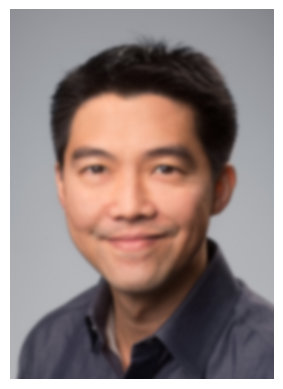

In [207]:
plt.imshow(blurred)
plt.axis('off')
plt.show()

#### Bilateral filtering

In [133]:
img = img.convert('RGB') 
img_np = np.array(img)
img_cv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

filtered = np.zeros_like(img_cv)
for i in range(3): 
    filtered[:, :, i] = cv2.bilateralFilter(img_cv[:, :, i], d=15, sigmaColor=75, sigmaSpace=75)

filtered_rgb = cv2.cvtColor(filtered, cv2.COLOR_HSV2RGB)
img = Image.fromarray(filtered_rgb)

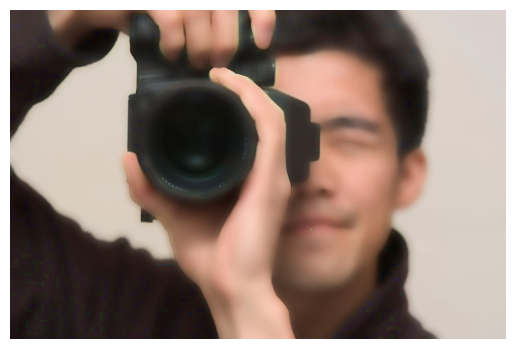

In [134]:
plt.imshow(img)
plt.axis('off')
plt.show()

### Code for Kuwahara filter below (could prob be optimized)

In [235]:
window_size = 10

# Convert to HSV and get NumPy array once
img = img.convert('HSV')
img_np = np.array(img)
height, width = img.height, img.width

# New image to store results
result_np = np.zeros_like(img_np)

# Size of each quadrant of a window
quadrant_size = math.ceil(window_size / 2)

for y in range(0, height, 2):
    for x in range(0, width, 2):
        tl_x = max(0, int(np.floor(x - (window_size / 2))))
        tl_y = max(0, int(np.floor(y - (window_size / 2))))
        mid_x = min(width, tl_x + quadrant_size)
        mid_y = min(height, tl_y + quadrant_size)
        wind_x = min(width, tl_x + window_size)
        wind_y = min(height, tl_y + window_size)

        # Extract quadrants
        quadrant_a = img_np[tl_y:mid_y, tl_x:mid_x]
        quadrant_b = img_np[tl_y:mid_y, mid_x:wind_x]
        quadrant_c = img_np[mid_y:wind_y, tl_x:mid_x]
        quadrant_d = img_np[mid_y:wind_y, mid_x:wind_x]

        quadrants = [quadrant_a, quadrant_b, quadrant_c, quadrant_d]

        # compute stdevs
        sigmas = []
        for q in quadrants:
            if q.size == 0:
                sigmas.append(np.inf)
            else:
                sigmas.append(np.std(q[:, :, 2]))

        # Select quadrant with least std dev
        minIndex = np.argmin(sigmas)
        quadrant = quadrants[minIndex]

        # Average H, S, V values
        h = int(np.mean(quadrant[:, :, 0]))
        s = int(np.mean(quadrant[:, :, 1]))
        v = int(np.mean(quadrant[:, :, 2]))

        result_np[y, x] = [h, s, v]

        for dy in range(2):
            for dx in range(2):
                yy = y + dy
                xx = x + dx
                if yy < height and xx < width:
                    result_np[yy, xx] = [h, s, v]

result = Image.fromarray(result_np, 'HSV')


In [243]:
blurred = result.convert('RGB').filter(ImageFilter.GaussianBlur(radius=1.75))

In [216]:
# interpolation
small_result = result.resize((width//2, height//2), Image.BILINEAR)
result_blended = small_result.resize((width, height), Image.BICUBIC)
large_result = result.resize((width*2, height*2), Image.BICUBIC)

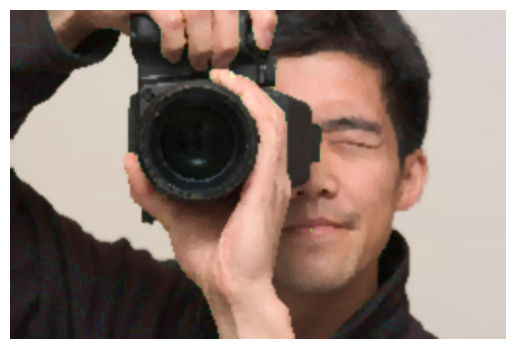

In [217]:
plt.imshow(result_blended)
plt.axis('off')
plt.show()

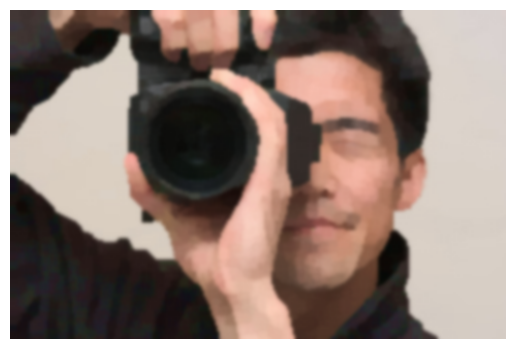

In [244]:
plt.imshow(blurred)
plt.axis('off')
plt.show()

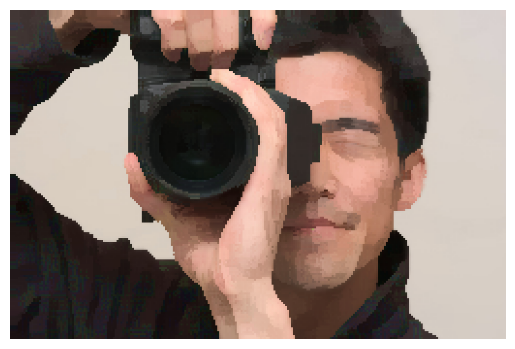

In [237]:
plt.imshow(result)
plt.axis('off')
plt.show()